In [132]:
%matplotlib widget

import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton, MouseEvent
import geoengine as ge
from geoengine.workflow_builder.operators import TemporalRasterAggregation, RasterStacker, RenameBands, \
    RasterTypeConversion, Expression, GdalSource, RasterVectorJoin, OgrSource, Onnx
import numpy as np
from typing import Tuple, Callable, Optional
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import xarray as xr
from sklearn.ensemble import RandomForestClassifier
from skl2onnx import to_onnx # TODO: in ge library
from geoengine_openapi_client.models import MlModelMetadata, RasterDataType # TODO: better import

In [2]:
def points_by_drawing(filename: str,
                      color: str,
                      crs: str,
                      background: Callable[[plt.Axes], None],
                      figsize: Optional[Tuple[int, int]] = None) -> None:

    try:
        points = gpd.read_file(filename)
        points.set_crs(crs, inplace=True, allow_override=True)
    except:
        points = gpd.GeoDataFrame(crs=crs, geometry=[])

    fig, ax = plt.subplots(figsize=figsize)

    background(ax)

    def on_click(event: MouseEvent):
        if event.button is not MouseButton.LEFT:
            return
        if not event.inaxes:
            return
        
        points.loc[len(points)] = [Point(event.xdata, event.ydata)]

        points.plot(ax=ax, c=color)

        points.to_file(filename)

    fig.canvas.mpl_connect('button_press_event', on_click)

    points.plot(ax=ax, c=color)


In [3]:
koeln_center_utm = [356766, 5644819]

In [4]:
ge.initialize("http://localhost:3030/api")

In [93]:
def _query_rectangle(*,
                     center: Tuple[float, float],
                     time: np.datetime64,
                     radius_px: float = 512) -> ge.QueryRectangle:
    resolution = ge.SpatialResolution(10, 10)
    bbox = ge.BoundingBox2D(
        xmin=center[0] - resolution.x_resolution * radius_px,
        xmax=center[0] + resolution.x_resolution * radius_px,
        ymin=center[1] - resolution.y_resolution * radius_px,
        ymax=center[1] + resolution.y_resolution * radius_px,
    )
    return ge.QueryRectangle(
        spatial_bounds=bbox,
        time_interval=ge.TimeInterval(time),
        srs='EPSG:32632',
        resolution=resolution,
    )

red_band = GdalSource("_:5779494c-f3a2-48b3-8a2d-5fbba8c5b6c5:`UTM32N:B04`")
green_band = GdalSource("_:5779494c-f3a2-48b3-8a2d-5fbba8c5b6c5:`UTM32N:B03`")
blue_band = GdalSource("_:5779494c-f3a2-48b3-8a2d-5fbba8c5b6c5:`UTM32N:B02`")
nir_band = GdalSource("_:5779494c-f3a2-48b3-8a2d-5fbba8c5b6c5:`UTM32N:B08`")
mask_band = RasterTypeConversion(
    GdalSource("_:5779494c-f3a2-48b3-8a2d-5fbba8c5b6c5:`UTM32N:SCL`"),
    output_data_type='U16',
)

workflow = TemporalRasterAggregation(
    aggregation_type='mean',
    granularity='months',
    window_size=1,
    ignore_no_data=True,
    source=RasterStacker(
        sources=[
            Expression(
                expression="if (B == 3 || (B >= 7 && B <= 11)) { NODATA } else { A }",
                output_type="F32",
                source=RasterStacker([red_band, mask_band]),
            ),
            Expression(
                expression="if (B == 3 || (B >= 7 && B <= 11)) { NODATA } else { A }",
                output_type="F32",
                source=RasterStacker([green_band, mask_band]),
            ),
            Expression(
                expression="if (B == 3 || (B >= 7 && B <= 11)) { NODATA } else { A }",
                output_type="F32",
                source=RasterStacker([blue_band, mask_band]),
            ),
            Expression(
                expression="if (C == 3 || (C >= 7 && C <= 11)) { NODATA } else { (A - B) / (A + B) }",
                output_type="F32",
                source=RasterStacker([nir_band, red_band, mask_band]),
            ),
            # RasterTypeConversion(
            #     ge.workflow_builder.blueprints.sentinel2_cloud_free_band("B04"),
            #     output_data_type="F32",
            # ),
            # RasterTypeConversion(
            #     ge.workflow_builder.blueprints.sentinel2_cloud_free_band("B03"),
            #     output_data_type="F32",
            # ),
            # RasterTypeConversion(
            #     ge.workflow_builder.blueprints.sentinel2_cloud_free_band("B02"),
            #     output_data_type="F32",
            # ),
            # ge.workflow_builder.blueprints.sentinel2_cloud_free_ndvi(),
        ],
        rename=RenameBands.rename(['red', 'green', 'blue', 'ndvi']),
    )
)

workflow = ge.register_workflow(workflow)

query_rectangle = _query_rectangle(
    center=koeln_center_utm,
    time=np.datetime64("2022-07-01T00:00:00"),
    radius_px=512,
)

data_array = await workflow.raster_stream_into_xarray(
    query_rectangle=query_rectangle,
    clip_to_query_rectangle=True,
    bands=[0,1,2,3], # TODO: improve for user, default = all? where are the band names?
)


/home/beilschmidt/git/geoengine-python/env/lib/python3.10/site-packages/rasterio/windows.py:314: RasterioDeprecationWarning: The height, width, and precision parameters are unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(


/home/beilschmidt/git/geoengine-python/env/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


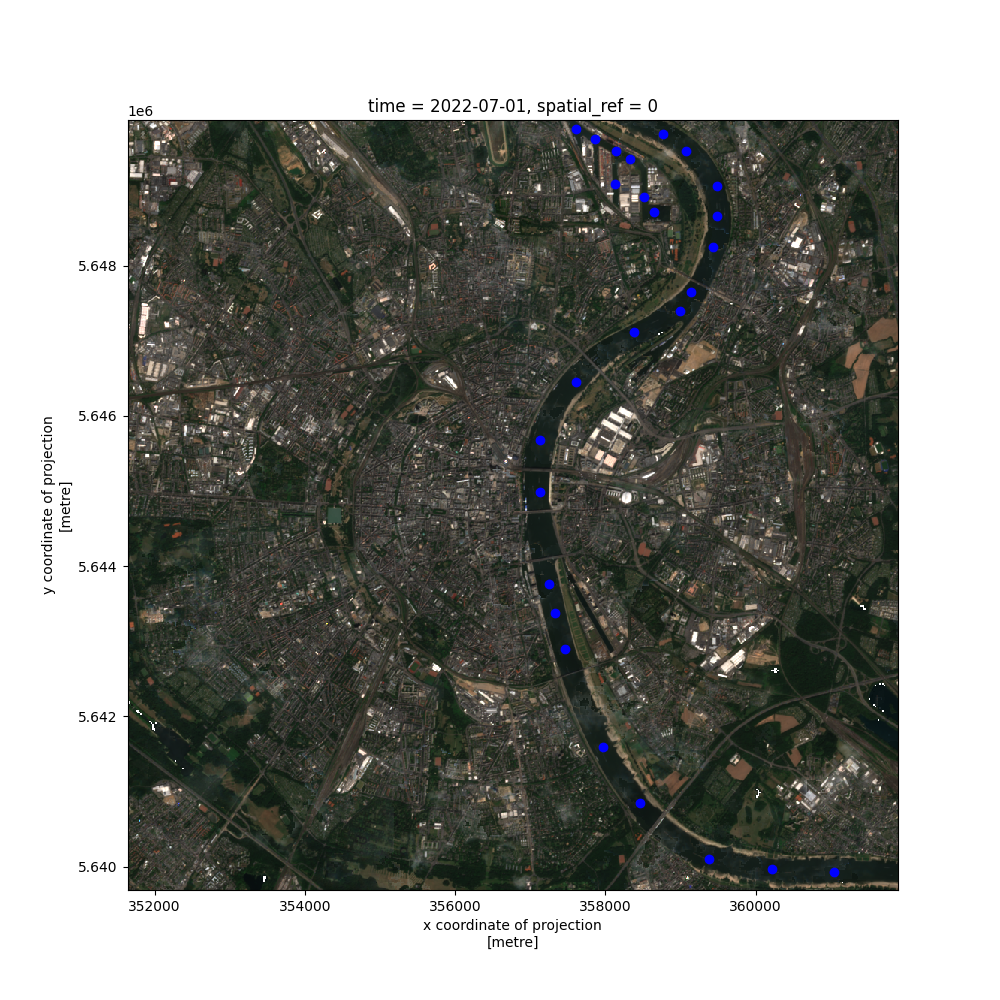

In [180]:
points_by_drawing(
    "water.geojson",
    color="blue",
    crs=str(data_array.rio.crs),
    background=lambda ax: data_array.isel(time=0, band=[0,1,2]).plot.imshow(
        rgb="band",
        vmax=4000,
        ax=ax,
    ),
    figsize=(10,10),
)

/home/beilschmidt/git/geoengine-python/env/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


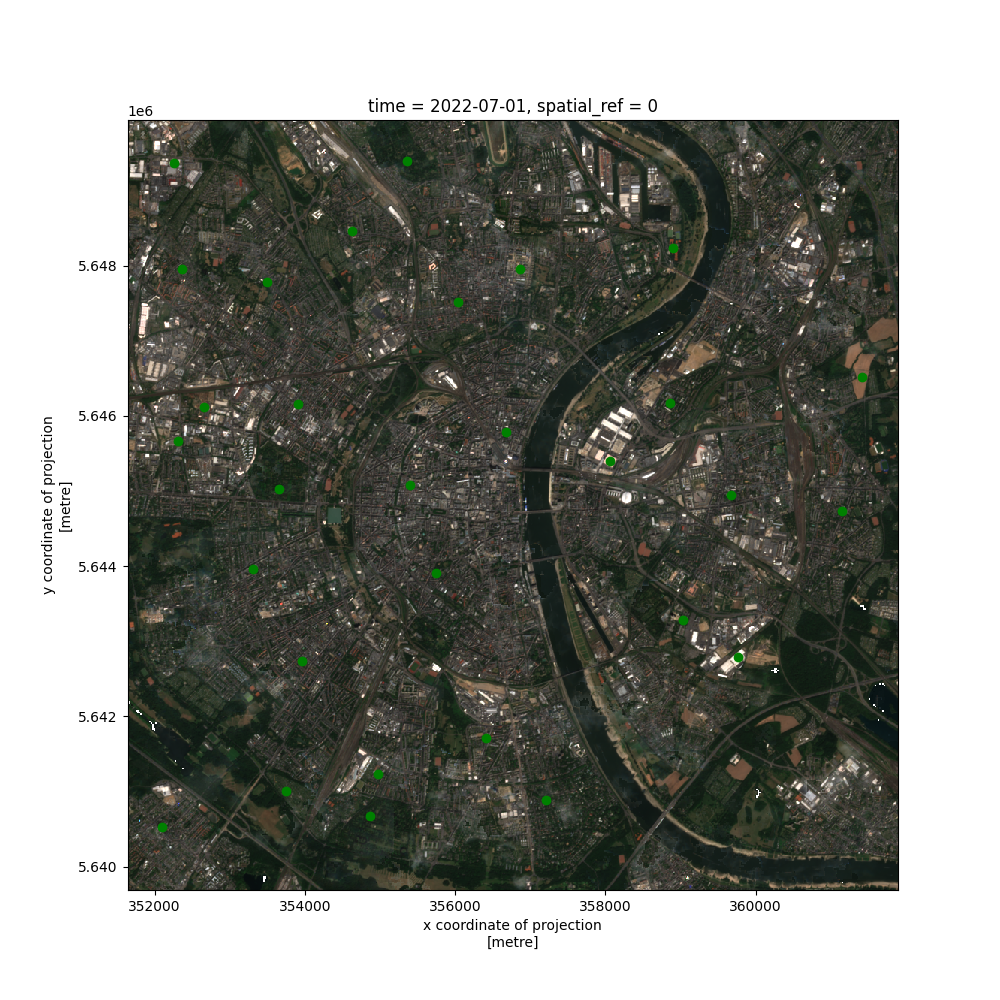

In [7]:
points_by_drawing(
    "non_water.geojson",
    color="green",
    crs=str(data_array.rio.crs),
    background=lambda ax: data_array.isel(time=0, band=[0,1,2]).plot.imshow(
        rgb="band",
        vmax=4000,
        ax=ax,
    ),
    figsize=(10,10),
)

In [97]:
labels = pd.concat(
    [
        gpd.read_file("water.geojson").assign(water=1),
        gpd.read_file("non_water.geojson").assign(water=0),
    ],
    ignore_index=True,
).set_crs(
    str(data_array.rio.crs),
    allow_override=True,
# ).assign(
#     start="2022-07-01",
#     end="2022-08-01"
)

labels_name = ge.upload_dataframe(
    labels,
    # time=ge.datasets.OgrSourceDatasetTimeType.start_end(
    #     start_field="start",
    #     start_format=ge.datasets.OgrSourceTimeFormat.auto(),
    #     end_field="end",
    #     end_format=ge.datasets.OgrSourceTimeFormat.auto(),
    # )
)

labels_name

ddeeddd5-a45d-40cc-b692-a005f93643df:82b7a3b3-8b88-45a7-b21b-295549e7ff9f

In [98]:
training_workflow = RasterVectorJoin(
    raster_sources=[workflow.workflow_definition().operator],
    vector_source=OgrSource(labels_name),
    names=ge.workflow_builder.operators.ColumnNames.default(),
    temporal_aggregation="none",
    feature_aggregation="first",
    temporal_aggregation_ignore_nodata=True,
    feature_aggregation_ignore_nodata=True,
)

training_workflow = ge.register_workflow(training_workflow)

training_df = training_workflow.get_dataframe(query_rectangle)

training_df.head()

geometry        blue       green      ndvi  \
0  POINT (359492.047 5649059.959)  458.799988  485.799988 -0.158283   
1  POINT (359436.582 5648255.711)  395.500000  439.250000 -0.203166   
2  POINT (361045.078 5639935.905)  502.500000  561.666687 -0.239277   
3  POINT (359381.116 5640102.302)  416.000000  478.399994 -0.160315   
4  POINT (357966.750 5641599.867)  412.500000  486.000000 -0.079246   

          red  water                     start                       end  
0  328.399994      1 2022-07-01 00:00:00+00:00 2022-08-01 00:00:00+00:00  
1  279.000000      1 2022-07-01 00:00:00+00:00 2022-08-01 00:00:00+00:00  
2  407.500000      1 2022-07-01 00:00:00+00:00 2022-08-01 00:00:00+00:00  
3  337.200012      1 2022-07-01 00:00:00+00:00 2022-08-01 00:00:00+00:00  
4  332.666656      1 2022-07-01 00:00:00+00:00 2022-08-01 00:00:00+00:00

In [99]:
training_workflow.get_result_descriptor()

Data type:         MultiPoint
Spatial Reference: EPSG:32632
Columns:
  red:
    Column Type: float
    Measurement: unitless
  green:
    Column Type: float
    Measurement: unitless
  ndvi:
    Column Type: float
    Measurement: unitless
  blue:
    Column Type: float
    Measurement: unitless
  water:
    Column Type: int
    Measurement: unitless

/home/beilschmidt/git/geoengine-python/env/lib/python3.10/site-packages/geopandas/plotting.py:644: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  warnings.warn(


<Axes: title={'center': 'time = 2022-07-01, spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

/home/beilschmidt/git/geoengine-python/env/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


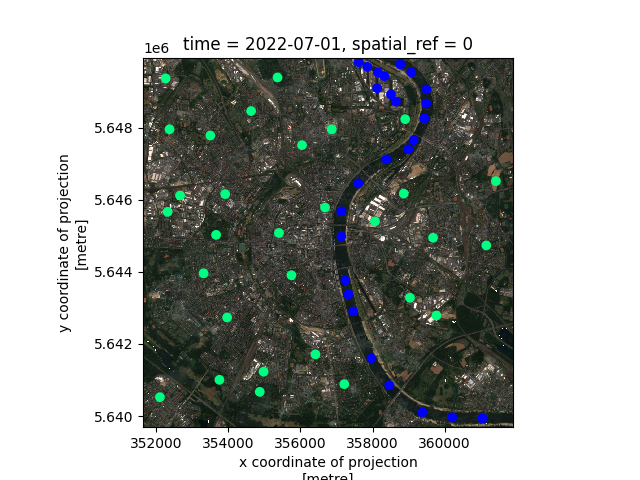

In [196]:
fig, ax = plt.subplots()

data_array.isel(time=0, band=[0,1,2]).plot.imshow(
    rgb="band",
    vmax=4000,
    ax=ax,
)

training_df.plot(ax=ax, column="water", k=2, colormap="winter_r")

In [144]:
X = training_df[["red", "green", "blue", "ndvi"]].to_numpy().astype(np.float32)
print(X[:5])

[[ 3.2839999e+02  4.8579999e+02  4.5879999e+02 -1.5828317e-01]
 [ 2.7900000e+02  4.3925000e+02  3.9550000e+02 -2.0316632e-01]
 [ 4.0750000e+02  5.6166669e+02  5.0250000e+02 -2.3927733e-01]
 [ 3.3720001e+02  4.7839999e+02  4.1600000e+02 -1.6031471e-01]
 [ 3.3266666e+02  4.8600000e+02  4.1250000e+02 -7.9246230e-02]]


In [145]:
y = training_df["water"].to_numpy().astype(np.uint8)
print(y[:5])

[1 1 1 1 1]


In [146]:
clf = RandomForestClassifier(random_state=42)

clf.fit(X, y)

RandomForestClassifier(random_state=42)

In [147]:
onx = to_onnx(clf, X[:1], target_opset=9) # target_opset is the ONNX version to use

In [148]:
# print(onx)

from onnx.checker import check_model

check_model(onx)

In [150]:
model_name = f"{ge.get_session().user_id}:rf2"

metadata = MlModelMetadata(
    file_name="model.onnx", # always this?
    input_type=RasterDataType.F32,
    num_input_bands=4, # should know this
    output_type=RasterDataType.I64,
)

model_config = ge.ml.MlModelConfig(
    name=model_name,
    metadata=metadata,
    display_name="Decision Tree",
    description="A simple decision tree model",
)

ge.register_ml_model(onnx_model=onx, model_config=model_config)

In [151]:
model_workflow = Onnx(
    source=workflow.workflow_definition().operator,
    model=model_name,
)

model_workflow = ge.register_workflow(model_workflow)

model_workflow.get_result_descriptor()


Data type:         I64
Spatial Reference: EPSG:32632
Bands:
    prediction: unitless

In [153]:
classified_array = await model_workflow.raster_stream_into_xarray(
    query_rectangle=query_rectangle,
    clip_to_query_rectangle=True,
    bands=[0], # TODO: improve for user, default = all? where are the band names?
)

classified_array

/home/beilschmidt/git/geoengine-python/env/lib/python3.10/site-packages/rasterio/windows.py:314: RasterioDeprecationWarning: The height, width, and precision parameters are unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(


<xarray.DataArray (time: 1, band: 1, y: 1025, x: 1025)>
array([[[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]]])
Coordinates:
  * x            (x) float64 3.516e+05 3.517e+05 ... 3.619e+05 3.619e+05
  * y            (y) float64 5.65e+06 5.65e+06 5.65e+06 ... 5.64e+06 5.64e+06
  * time         (time) datetime64[ns] 2022-07-01
  * band         (band) int64 0
    spatial_ref  int64 0

/home/beilschmidt/git/geoengine-python/env/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


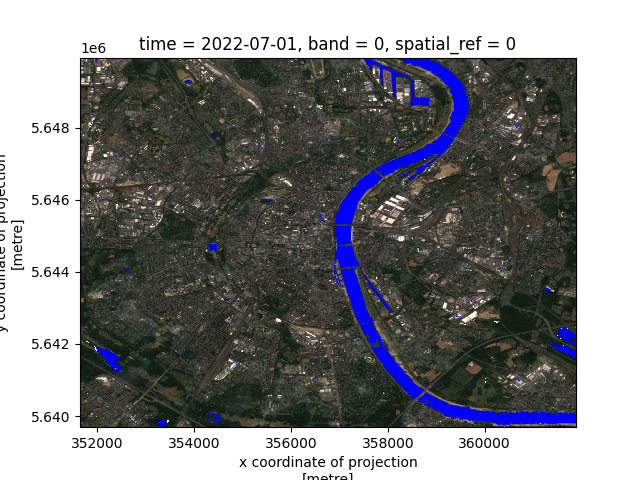

In [179]:
fig, ax = plt.subplots()

data_array.isel(time=0, band=[0,1,2]).plot.imshow(
    rgb="band",
    vmax=4000,
    ax=ax,
)

classified_array.isel(time=0, band=0).plot.imshow(ax=ax, levels=3, colors=["#00000000", "blue"], vmax=2, add_colorbar=False)

plt.show();